In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from tsaug import Drift, AddNoise, TimeWarp
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm
from pytz import timezone
import json
import os

In [2]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
SAMPLING_RATE = 1/60
IMAGE_HEIGHT = 370 # height size of standard spectrogram (matplotlib)
NFFT = 255 # 1 window in spectrogram is derived from NFFT datapoints
NOVERLAP = 128 # window hop in spectrogram

In [3]:
# User change:
NORMALIZE_SUBJECTS = True # whether to normalize all variables subject-wise (to counteract high subject variability)

SEGMENT_LENGTH = 370 # width of one segment [pixels] (full day data is 370x497 pixels)
OVERLAP = 0.75 # of neighbouring segments [%]
FILTER_THRESHOLD = 0.5 # discard segment if contains >FILTER_THRESHOLD aritificial data [%]
AUGMENTATION_SIZE = 0.5 # size of additional augmented datapoints relative to full dataset [%]
AUGMENTATION_PROB = 0.25 # probability of single augmentation

TIME_WARP_MIN, TIME_WARP_MAX = 1.01, 3.0 # maximal ratio of max/min speed in the warped time line
NOISE_MIN, NOISE_MAX = 0.01, 0.02 # add random noise up to MIN-MAX
MAGNITUDE_WARP_MIN, MAGNITUDE_WARP_MAX = 0.01, 0.05 # random drift the signal up to MIN-MA
SCALING_STD = 0.05 # scale time-series by N(1, SCALING_STD)

In [6]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def plotter_spec(day, dat, NFFT=256, noverlap=128):
    """
    Plots spectrograms of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.specgram(time_series, Fs=SAMPLING_RATE, NFFT=NFFT, noverlap=NOVERLAP)

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

'''def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2'''

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

def spectrogram_as_array(time_series, iteration=1):
    """
    Retrieves numerical data from spectrogram
    """
    # for stability
    time_series += np.random.normal(0.0, 1e-15)

    # calculate spectrogram
    fig = plt.figure()
    fig.add_subplot(111)
    plt.specgram(time_series,
                 Fs=SAMPLING_RATE,
                 NFFT=NFFT,
                 noverlap=NOVERLAP)
    plt.axis('off') # removes everything except content of plot

    # need to draw plot to create spectrogram
    fig.canvas.draw()

    # save pixels in numpy array
    numerical = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    numerical = numerical.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close() # prevent showing plot

    # remove white padding around spectrogram image
    height, width, channels = numerical.shape
    all_white_rows = np.where(np.sum(numerical[:, :, 0], axis=1) == 255 * width)[0]
    all_white_cols = np.where(np.sum(numerical[:, :, 0], axis=0) == 255 * height)[0]

    start_row, end_row = max(all_white_rows[all_white_rows - np.mean(all_white_rows) < 0]), \
                         min(all_white_rows[all_white_rows - np.mean(all_white_rows) > 0])
    start_col, end_col = max(all_white_cols[all_white_cols - np.mean(all_white_cols) < 0]), \
                         min(all_white_cols[all_white_cols - np.mean(all_white_cols) > 0])

    numerical = numerical[start_row:end_row, start_col:end_col, :]
    return numerical

def save_spectrogram(spectrogram, name):
    """
    Saves spectrogram as png
    """
    plt.figure()
    plt.imshow(spectrogram)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'./Output/{name}.png')
    plt.close() # prevent showing plot

def segmentor(image):
    """
    Segments images into subimages (along width axis)
    """
    height, width, channels = image.shape
    segments = []
    delta = int((1 - OVERLAP) * SEGMENT_LENGTH) # distance between two windows

    start, end = 0, SEGMENT_LENGTH
    while True:
        # check if building one more segment is possible
        if end > width - 1: # last pixel column is image[:, width - 1, :]
            break
        else:
            # possible to build segment
            segment = image[:, start:end, :]
            segments.append(segment)

        # move window further
        start += delta
        end += delta

    return segments

def plot_segments(image):
    """
    Plots image with visible segmentations
    """
    segments = segmentor(image)

    plt.figure()
    n = len(segments)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(segments[i])
        plt.xticks([]), plt.yticks([])

def tz_diff(date, tz1, tz2):
    """
    Returns the difference in hours between timezone1 and timezone2
    for a given date.
    """
    tz1 = 'CET' if tz1 == 'CEST' else tz1 # CEST is just summertime CET
    tz2 = 'CET' if tz2 == 'CEST' else tz2 # CEST is just summertime CET

    date = pd.to_datetime(date)
    tz1, tz2 = timezone(tz1), timezone(tz2)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds / 3600

def imputer(dat, method, **kwargs):
    """Imputes data by day (!) according to specified method"""
    data_imputed = dat.copy()

    assert method in ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest')
    if method == 'mean':
        value = data_imputed.mean(axis=1)
        data_imputed = data_imputed.transpose().fillna(value).transpose() # not very pretty but works
    elif method == 'median':
        value = data_imputed.median(axis=1)
        data_imputed = data_imputed.transpose().fillna(value).transpose() # not very pretty but works
    elif method == 'mode':
        value = data_imputed.mode(axis=1)[0]
        data_imputed = data_imputed.transpose().fillna(value).transpose() # not very pretty but works
    else:
        MAX_FILL = 1440 # maximum imputation window (from both sides!)
        data_imputed = data_imputed.interpolate(method=method, axis=1, limit=MAX_FILL, limit_direction='both', fill_value='extrapolate', **kwargs)

    return data_imputed

def visualize_imputation(dat, method, **kwargs):
    """Plots data vs. imputed data"""
    data_imputed = imputer(dat, method, **kwargs)

    # visualize imputation
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.7,
                        top=1.0,
                        wspace=0.4,
                        hspace=0.4)

    for i, variable in enumerate(VARIABLES):
        plt.subplot(2, 5, i+1)
        plt.title(variable)

        # post-imputation
        ax = data_imputed.iloc[i].plot(color='red', linewidth=1.0)
        ax.set_xticklabels([], minor=True)

        # pre-imputation
        ax = dat.iloc[i].plot()
        ax.set_xticklabels([], minor=True)

# Import data

In [7]:
# file path to data folder
path = './Output'

In [8]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Discarding data 1/2

Filter out variables from dataset

Text(0, 0.5, 'available data [%]')

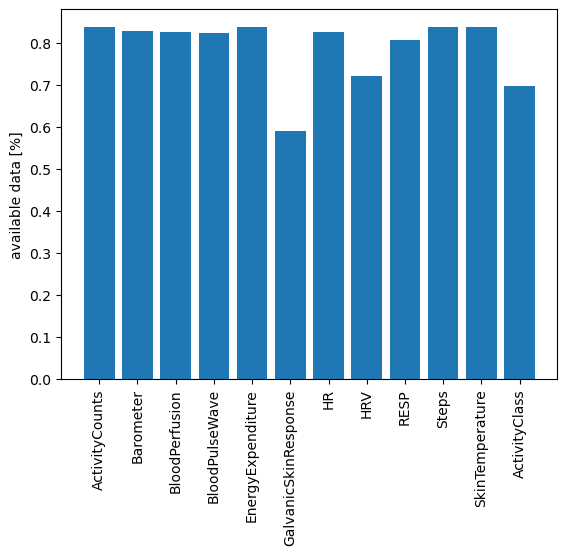

In [9]:
# missing data per variable
temp = missing_data_per_variable(data)

plt.bar(x=temp.keys(), height=temp.values())
plt.xticks(rotation=90)
plt.ylabel('available data [%]')

In [10]:
# discard variables from dataset (too much missing data)
to_discard = ['GalvanicSkinResponse', 'ActivityClass']

data = data.drop(columns=to_discard)
VARIABLES = [variable for variable in VARIABLES if variable not in to_discard]

Filter out days with few data

In [11]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    time_series = get_time_series(data, VARIABLES[0], day)
    length = len(time_series)

    # if cannot build at least one segment -> discard day
    if length < SEGMENT_LENGTH:
        discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (few data): {discarded_days}')

Discarded days (few data): [7, 312, 357]


Filter out days with sensors out all days

In [12]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) == 0: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days}')

Discarded days (sensor out): [113]


# Normalization

# TODO: WE NORMALIZE AFTER IMPUTATION

In [13]:
'''if NORMALIZE_SUBJECTS:
    # normalize each variable considering only subject data
    days, _ = data.shape
    for subject in np.unique(data['subjectID']):
        days_subj = np.arange(days)[data['subjectID'] == subject]

        for variable in [var for var in VARIABLES if var != 'ActivityClass']: # don't normalize categorical var.
            # get mean, variance of all subject data
            full_time_series = np.array([datapoint for day in days_subj for datapoint in get_time_series(data, variable, day)]).reshape(-1, 1)
            scaler = StandardScaler()
            scaler.fit(full_time_series)

            # normalize accordingly
            for day in days_subj:
                time_series = get_time_series(data, variable, day).reshape(-1, 1)
                data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)'''

"if NORMALIZE_SUBJECTS:\n    # normalize each variable considering only subject data\n    days, _ = data.shape\n    for subject in np.unique(data['subjectID']):\n        days_subj = np.arange(days)[data['subjectID'] == subject]\n\n        for variable in [var for var in VARIABLES if var != 'ActivityClass']: # don't normalize categorical var.\n            # get mean, variance of all subject data\n            full_time_series = np.array([datapoint for day in days_subj for datapoint in get_time_series(data, variable, day)]).reshape(-1, 1)\n            scaler = StandardScaler()\n            scaler.fit(full_time_series)\n\n            # normalize accordingly\n            for day in days_subj:\n                time_series = get_time_series(data, variable, day).reshape(-1, 1)\n                data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)"

In [14]:
# visualize
'''plotter(np.random.choice(data.shape[0], 1, replace=False)[0], data)'''

'plotter(np.random.choice(data.shape[0], 1, replace=False)[0], data)'

# Imputation

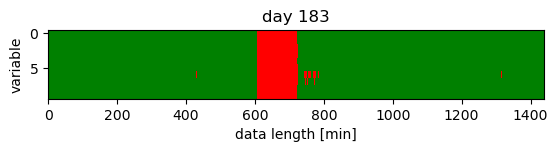

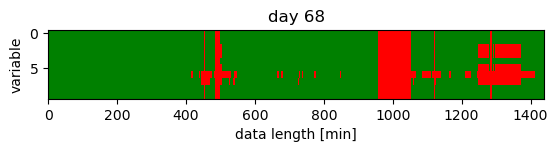

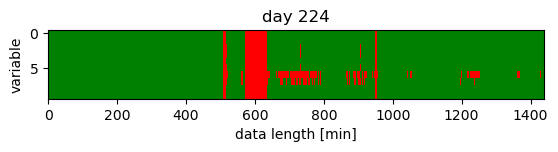

In [15]:
# visualize missing data (red: missing data, green: data)
N = 3
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

Format data into daily dataframes (for imputation model)

In [46]:
def data_to_days(dat) -> list:
    """
    Returns a list of daily data (needed for imputation)
    :param dat: full data
    :return: list of daily data
    """
    data_daily = []

    n_days, _ = dat.shape
    for day in range(n_days):
        # create dataframe with data by day (i.e. each row is full daily data of one variable, each column is a one-minute measurement)

        # timestamps
        date = data["date"].iloc[day] # date (year, month, day) of current day
        timestamps_full = pd.to_datetime(
            [f'{str(hour)}:{str(minute)}, {date}' for hour in range(0, 24)
             for minute in range(0, 60)]) # timestamps for one full day
        timestamps_available = pd.to_datetime(
            [f'{ts}, {date}' for ts in dat['Timestamps'].iloc[day].split(',')]) # timestamps with data

        # assign data to correct timestamp
        rows = [{timestamp: np.NaN for timestamp in timestamps_full} for variable in VARIABLES] # initialize full day with NaNs
        rows_available = [get_time_series(dat, variable, day) for variable in VARIABLES] # available data for day
        for variable, _ in enumerate(VARIABLES):
            for i, timestamp in enumerate(timestamps_available):
                rows[variable][timestamp] = rows_available[variable][i] # fill timestamps where we have data

        # build dataframe
        row_names = VARIABLES
        column_names = timestamps_full
        data_day = pd.DataFrame(data=rows,
                                index=row_names,
                                columns=column_names)

        data_daily.append(data_day)

    return data_daily

In [47]:
data_daily = data_to_days(data)

In [361]:
'''# create dataframe with data by day (i.e. each row is full daily data of one variable, each column is a one-minute measurement)
day = 0

# timestamps
date = data["date"].iloc[day]
timestamps_full = pd.to_datetime([f'{str(hour)}:{str(minute)}, {date}' for hour in range(0, 24) for minute in range(0, 60)]) # timestamps for one full day
timestamps_available = pd.to_datetime([f'{ts}, {date}' for ts in data.Timestamps[0].split(',')]) # timestamps with data

# assign data to correct timestamp
rows = [{timestamp: np.NaN for timestamp in timestamps_full} for variable in VARIABLES] # initialize full day with NaNs
rows_available = [get_time_series(data, variable, day) for variable in VARIABLES] # available data for day
for variable, _ in enumerate(VARIABLES):
    for i, timestamp in enumerate(timestamps_available):
        rows[variable][timestamp] = rows_available[variable][i] # fill timestamps where we have data

# build dataframe
row_names = VARIABLES
column_names = timestamps_full
data_day = pd.DataFrame(data=rows,
                        index=row_names,
                        columns=column_names)
data_day'''

'# create dataframe with data by day (i.e. each row is full daily data of one variable, each column is a one-minute measurement)\nday = 0\n\n# timestamps\ndate = data["date"].iloc[day]\ntimestamps_full = pd.to_datetime([f\'{str(hour)}:{str(minute)}, {date}\' for hour in range(0, 24) for minute in range(0, 60)]) # timestamps for one full day\ntimestamps_available = pd.to_datetime([f\'{ts}, {date}\' for ts in data.Timestamps[0].split(\',\')]) # timestamps with data\n\n# assign data to correct timestamp\nrows = [{timestamp: np.NaN for timestamp in timestamps_full} for variable in VARIABLES] # initialize full day with NaNs\nrows_available = [get_time_series(data, variable, day) for variable in VARIABLES] # available data for day\nfor variable, _ in enumerate(VARIABLES):\n    for i, timestamp in enumerate(timestamps_available):\n        rows[variable][timestamp] = rows_available[variable][i] # fill timestamps where we have data\n\n# build dataframe\nrow_names = VARIABLES\ncolumn_names = tim

Normalize day-variable-wise

In [52]:
def normalize_daily_variables(data_day):
    """Normalized each variable in data of one
    day"""
    n_rows, n_cols = data_day.shape
    for row in range(n_rows):
        data_day.iloc[row, :] = StandardScaler().fit_transform(np.array([data_day.iloc[row, :]]).reshape(-1, 1)).reshape(-1)

def normalize_by_day(dat):
    """Normalizes each day variable-wise"""
    for data_day in dat:
        normalize_daily_variables(data_day)

In [363]:
'''n_rows, n_cols = data_day.shape
for row in range(n_rows):
    data_day.iloc[row, :] = StandardScaler().fit_transform(np.array([data_day.iloc[row, :]]).reshape(-1, 1)).reshape(-1)'''

'n_rows, n_cols = data_day.shape\nfor row in range(n_rows):\n    data_day.iloc[row, :] = StandardScaler().fit_transform(np.array([data_day.iloc[row, :]]).reshape(-1, 1)).reshape(-1)'

In [53]:
normalize_by_day(data_daily)

Imputation methods

In [89]:
# choose day
day = 400
data_day = data_daily[day]

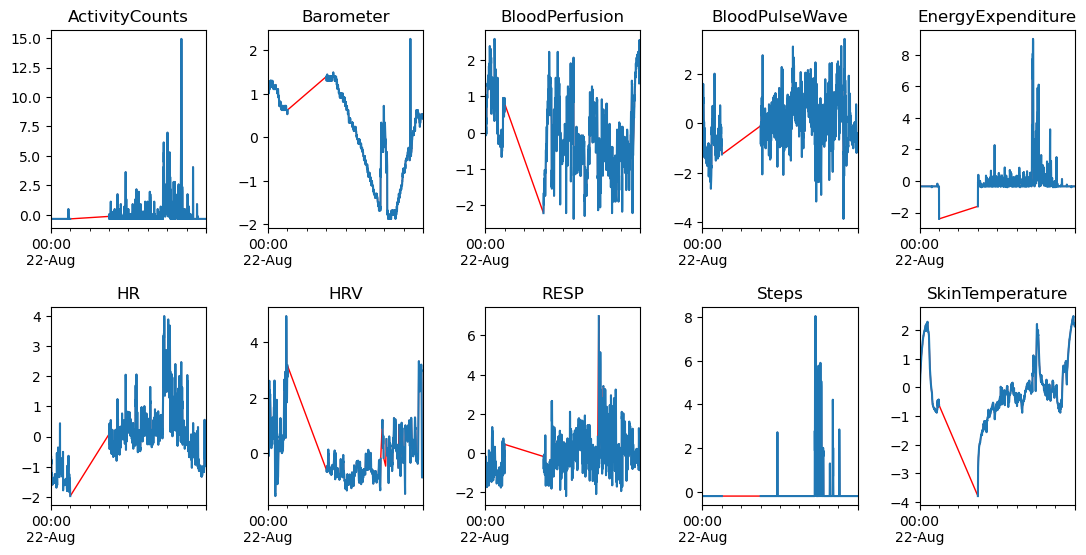

In [74]:
visualize_imputation(data_day, 'linear')

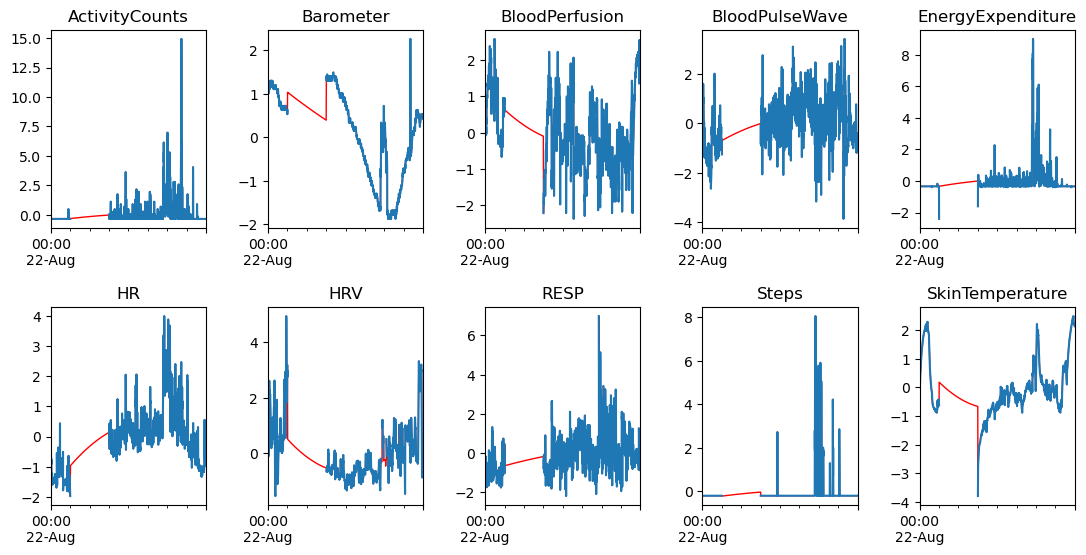

In [83]:
visualize_imputation(data_day, 'spline', order=2)

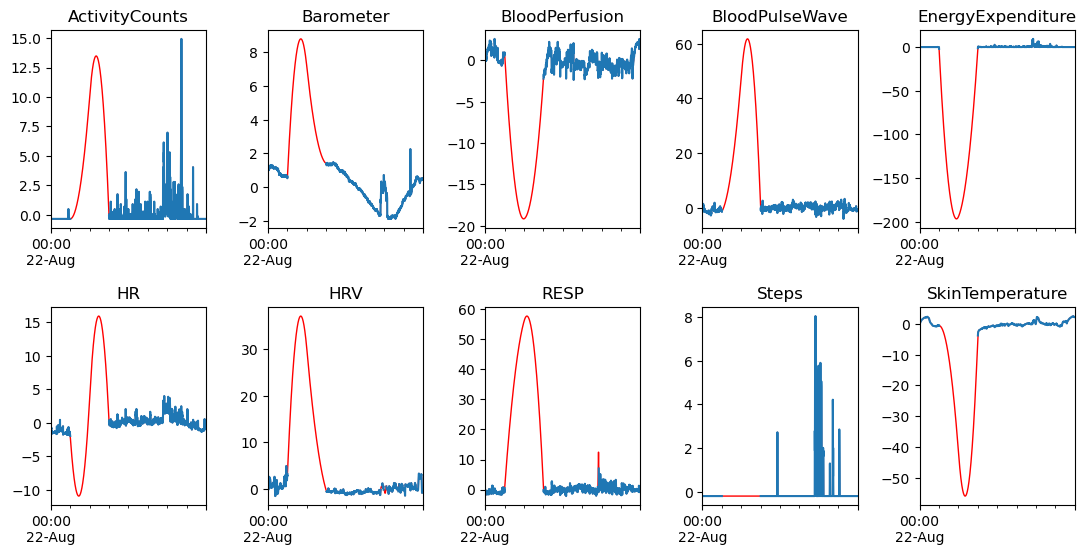

In [76]:
visualize_imputation(data_day, 'quadratic')

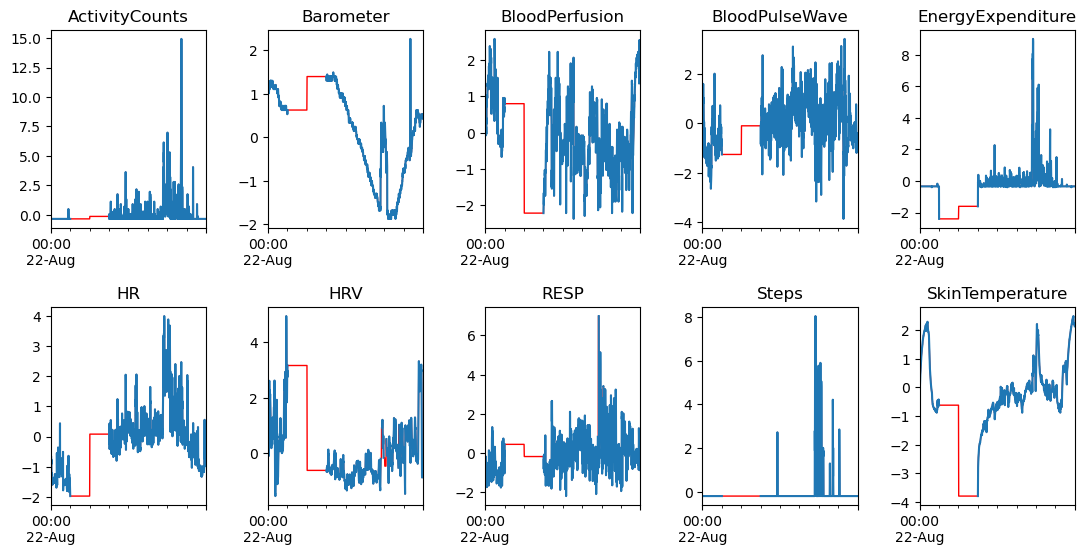

In [77]:
visualize_imputation(data_day, 'nearest')

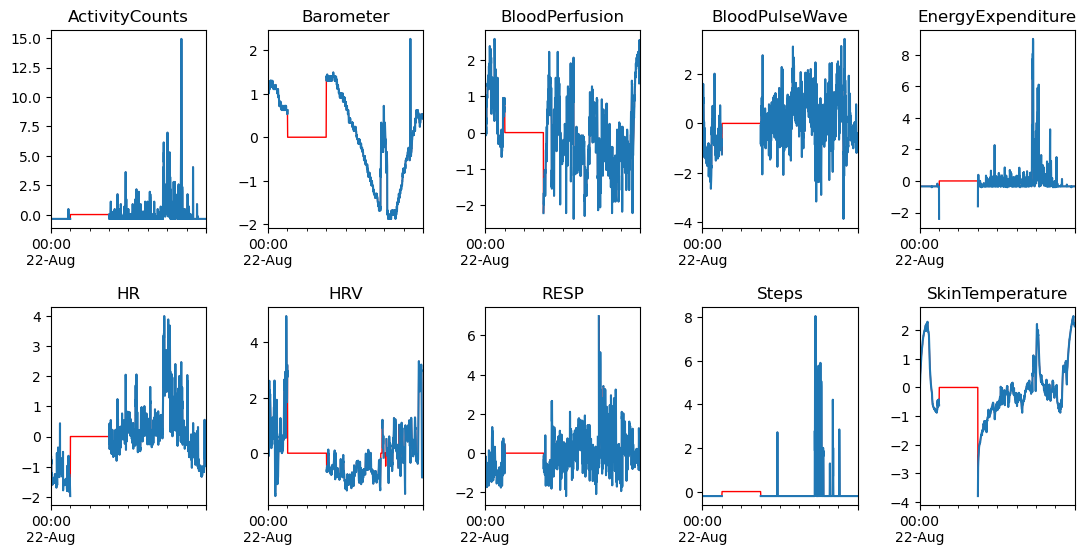

In [78]:
visualize_imputation(data_day, 'mean')

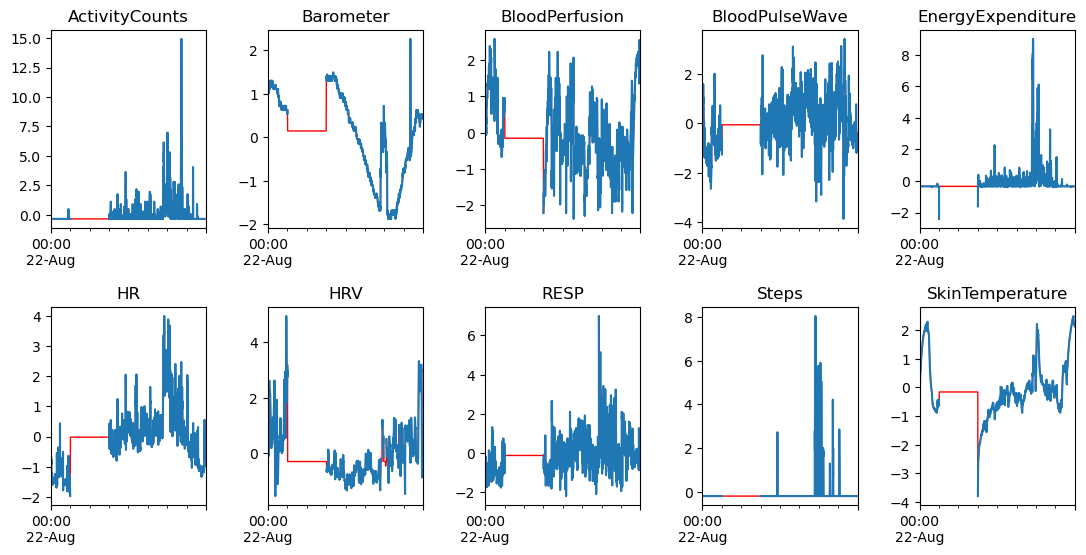

In [79]:
visualize_imputation(data_day, 'median')

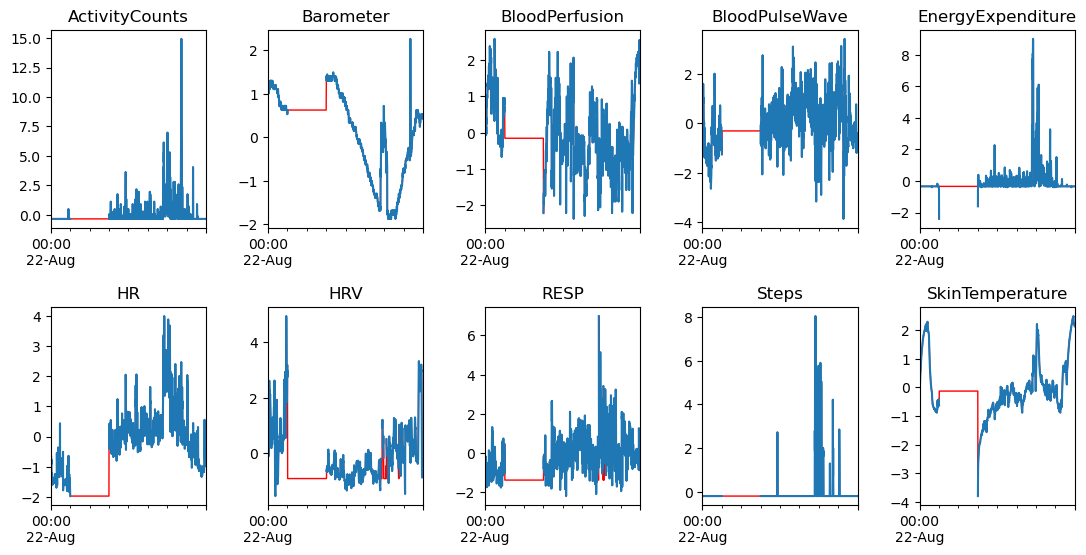

In [80]:
visualize_imputation(data_day, 'mode')

Note: general problem are long missing sequences, e.g.:

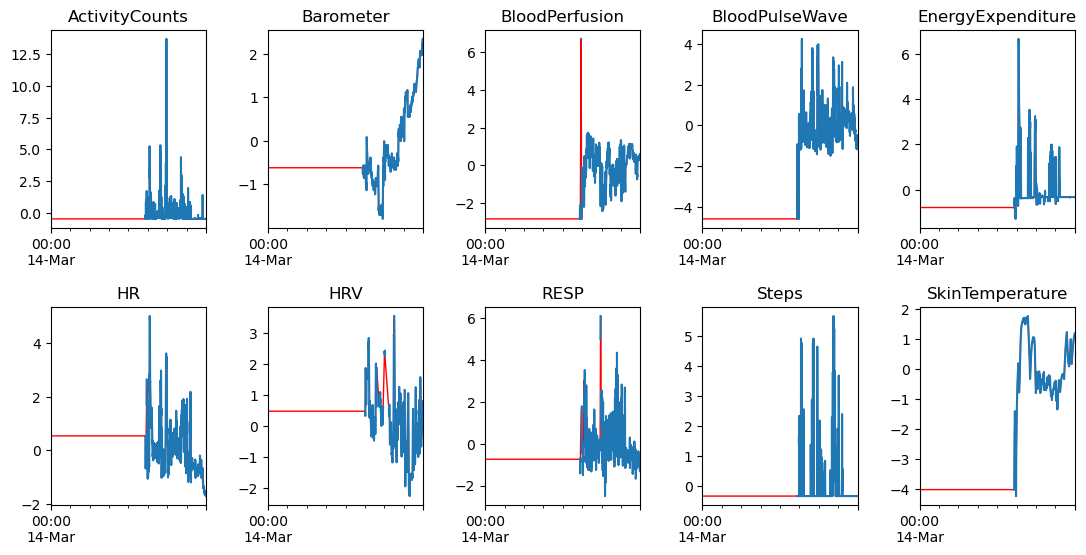

In [84]:
visualize_imputation(data_daily[0], 'linear')

Scoring of methods

In [85]:
def masker(dat, lm=3, masking_ratio=0.15):
    """
    Masks sequences (set to NaN) for training/testing
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mask of same shape as data with (0: available, 1: masked (purpose-fully set to NaN), 2: missing (NaN from beginning))
    """
    # full mask is for full day, mask is for one variable of the day
    full_mask = np.zeros(dat.shape) # whether datapoint is either: 0: available, 1: masked (purpose-fully set to NaN), 2: missing (NaN from beginning)

    for variable in range(dat.shape[0]):
        row = dat.iloc[variable]

        # init mask
        mask = np.zeros(1440) # whether datapoint is either: 0: available, 1: masked (purpose-fully set to NaN), 2: missing (NaN from beginning)
        mask[np.isnan(row)] = 2 # set already missing data

        p_start_masking_seq = masking_ratio
        p_start_keep_seq = 1 - p_start_masking_seq
        p_terminate_masking_seq = 1 / lm
        p_terminate_keep_seq = p_terminate_masking_seq * masking_ratio / (1 - masking_ratio)

        data_missing = False # whether data is already missing (not purposefully masked)
        masking = (np.random.rand() < p_start_masking_seq) # True: we are in masking sequence, False: we are in keep sequence
        for i in range(len(row)):
            # check if datapoint is already missing
            data_missing = (mask[i] == 2)

            if not data_missing:
                # check if we just exited from already missing data sequence -> in that case start again in masking state with prob
                try:
                    if mask[i - 1] == 2:
                        masking = (np.random.rand() < p_start_masking_seq) # True: we are in masking sequence, False: we are in keep sequence
                except IndexError:
                    pass

                # assign masking or not
                mask[i] = int(masking) # 0: available, 1: masked (purpose-fully set to NaN), 2: missing (NaN from beginning)

                # check if we terminate sequence
                if np.random.rand() < {True: p_terminate_masking_seq, False: p_terminate_keep_seq}[masking]:
                    masking = not masking # masking -> keep, keep -> masking

        full_mask[variable, :] = mask

    return full_mask

In [90]:
def visualize_mask(mask):
    """
    Visualizes masked data (green: available data, red: already missing data, blue: masked data)
    :param mask: mask with same shape as data by day (!)
    """
    length = mask.shape[0]

    # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
    mask_copy = mask.copy()
    mask_copy[0, 0] = 0.0
    mask_copy[1, 0] = 1.0
    mask_copy[2, 0] = 2.0

    # plot
    cmap = matplotlib.colors.ListedColormap(['green', 'blue', 'red'])
    plt.figure()
    plt.imshow(mask_copy, cmap=cmap, aspect='20', interpolation='nearest')
    plt.title(f'day {day}')
    plt.xlabel('data length [min]')
    plt.ylabel('variable')
    #plt.colorbar()

In [106]:
mask = masker(data_day, lm=3, masking_ratio=0.15)

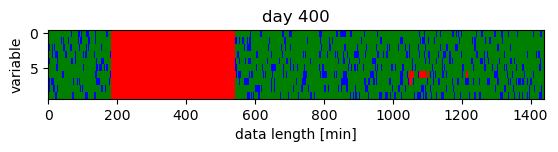

In [107]:
visualize_mask(mask)

In [108]:
def test_imputation(dat, mask, method, **kwargs):
    """
    Tests imputation method on data with mask
    :param dat: data by day (!)
    :param method: imputation method
    :param mask: of same shape as day
    :param kwargs: additional arguments for imputation
    :return: mean absolute error (MAE) on masked data
    """
    # impute masked data
    masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, dat)) # masked -> NaN
    data_imputed = imputer(masked_data, method, **kwargs)

    # calculate error
    real_data = dat.to_numpy()[mask == 1.0]
    imputed_data = data_imputed.to_numpy()[mask == 1.0]

    mae = np.mean(np.abs(real_data - imputed_data))

    return mae

In [112]:
def test_imputation_methods(dat, lm=3, masking_ratio=0.15) -> dict:
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) on masked data (sorted dict)
    """
    # create artificial mask
    # (0: available, 1: masked (purpose-fully set to NaN), 2: missing (NaN from beginning))
    mask = masker(dat=dat, lm=lm, masking_ratio=masking_ratio)

    scores = {}
    for imputation_method in ('mean', 'median', 'mode', 'linear',
                              'quadratic', 'spline', 'nearest'):
        scores[imputation_method] = test_imputation(dat,
                                                    method=imputation_method,
                                                    mask=mask,
                                                    order=2)

    return sorted(scores.items(), key=lambda x: x[1])

In [113]:
test_imputation_methods(data_day, lm=3, masking_ratio=0.15)

[('linear', 0.289583475361747),
 ('nearest', 0.3189163417891515),
 ('quadratic', 0.4534076774096453),
 ('spline', 0.5910134675024494),
 ('median', 0.6174149428143028),
 ('mean', 0.6705916488826473),
 ('mode', 0.9010979042163714)]

In [114]:
test_imputation_methods(data_day, lm=20, masking_ratio=0.15)

[('linear', 0.34246407095816134),
 ('nearest', 0.3834745087444965),
 ('median', 0.5411498905295352),
 ('spline', 0.5846086827542611),
 ('mean', 0.6257818188719492),
 ('mode', 0.8501732606827332),
 ('quadratic', 1.6359448150958449)]